In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

The file explain is a rtf file explaining which variables are numeric and which are categorical. There are 1765 variables, the first being ID and it's part in the explain file does not contain the target string 'the SPSS measurement level is'. The others' part contains either NOMINAL, ORDINAL or SCALE. Only SCALE is numeric.

column 'n1842' is epilepsy status

In [2]:
# file path of explain file
explain_path = '/Users/hung-yiwu/Documents/AC209a_project/data/ncds_sweep0-3/mrdoc/allissue/ncds0123_ukda_data_dictionary.rtf'

# open explain file
explain = open(explain_path, 'r')

# read the whole file as a single giant string
explain_text = explain.read()

# SPSS measurement level target string
target_string_1 = 'the SPSS measurement level is '

# locate SPSS measurement level
target_loc_1 = [m.end() for m in re.finditer(target_string_1, explain_text)]

# variable label target string
target_string_2 = 'Variable label = '

# locate variable label
target_loc_2 = [m.end() for m in re.finditer(target_string_2, explain_text)]

# remove the first one (id)
target_loc_2 = target_loc_2[1:]

# variable code target string
target_string_3 = 'Variable = '

# locate variable code
target_loc_3 = [m.end() for m in re.finditer(target_string_3, explain_text)]

# remove the first one (id)
target_loc_3 = target_loc_3[1:]

In [3]:
var_df = pd.DataFrame({}, columns = ['type', 'label'])

for i in range(len(target_loc_1)):
    # get variable code
    start_pt = target_loc_3[i]+15
    end_pt = explain_text.find('cf1', start_pt)-6
    var_code = explain_text[start_pt:end_pt]
    
    # get variable label
    start_pt = target_loc_2[i]+7
    end_pt = explain_text.find('\par', start_pt)
    var_label = explain_text[start_pt:end_pt]
    
    # get variable type
    char = explain_text[target_loc_1[i] + 9] 
    if char == 'O' or char == 'o' or char == 'N' or char == 'n' \
        or 'region' in var_code:
        var_type = 'categorical'
    else:
        var_type = 'numerical'

    # append to DataFrame
    var_df.loc[var_code] = [var_type, var_label]

In [4]:
print '{} variables'.format(var_df.shape[0])
print 'sample variable list:'
var_df.head()

1764 variables
sample variable list:


,type,label
n622,categorical,0-3D Sex of child
n0region,categorical,Region at PMS (1958) - Birth
n1region,categorical,Region at NCDS1 (1965) - 7 years
n2region,categorical,Region at NCDS2 (1969) - 11 years
n3region,categorical,Region at NCDS3 (1974) - 16 years


In [13]:
# file path of data file
data_path = './ncds_sweep0-3/tab/ncds0123.tab'

# read data file into Pandas DataFrame
# delimiter is tab
# use column 'ncdsid' as index
data = pd.read_csv(data_path, delimiter='\t').set_index('ncdsid')
y_df = data['n1842'].copy()
x_df = data.drop('n1842', axis = 1)

# get medical data column index
medical_col_index = [i for i, value in enumerate(var_df['label']) if\
       '1M' in value or '2M' in value or '3M' in value]
# get medical data columns
x_df = x_df.iloc[:, medical_col_index]

print '{} observations'.format(x_df.shape[0])
print '{} medical variables (before dummy expansion)'.format(x_df.shape[1])

# set y_df to binary: 5 or others
mask_1 = y_df == '5'
y_df[mask_1] = 1
y_df[~mask_1] = 0

print 'unique values in response variable:', y_df.unique()

18558 observations
338 medical variables (before dummy expansion)
unique values in response variable: [0.0 1.0]


Pos. = 353	Variable = n1842	Variable label = 12D Epilepsy identification

This variable is  numeric, the SPSS measurement level is ORDINAL

SPSS user missing values = -1.0 thru -2.0

	Value label information for n1842
	Value = 1.0	Label = No convulsiv dis
	Value = 2.0	Label = Indef convls dis
	Value = 3.0	Label = Faints
	Value = 4.0	Label = Hysterical attck
	Value = 5.0	Label = Epilepsy
	Value = 6.0	Label = Unsubstan epilep
	Value = 7.0	Label = Febr convs-prob
	Value = 8.0	Label = Febr convs -pos
	Value = 9.0	Label = Not diag epilep
	Value = 10.0	Label = Febrile convuls
	Value = 11.0	Label = Breath-holding
	Value = 12.0	Label = Blank-spells
	Value = -1.0	Label = Nt epilepsy stdy
	Value = -2.0	Label = No NCDS1,NCDS2

In [6]:
# iterate through all variables
# dummify categorical variables
# standardize numeric variables

x_df_extended_list = []

for col in x_df.columns:
    # if this column is categorical
    if var_df.loc[col, 'type'] == 'categorical':
        # copy current column
        curr_df = x_df[col].copy()
        # format all value to string
        curr_df = curr_df.astype(str)
        # set value ' ' to value '-1'
        curr_df[curr_df == ' '] = '-1'
        # if this column contains NaN
        if curr_df.isnull().values.any():
            # get dummy with NaN as a unique value
            dummy = pd.get_dummies(curr_df, dummy_na = True)
        # if this column does not contain NaN
        else:
            # get dummy without considering NaN
            dummy = pd.get_dummies(curr_df, dummy_na = False)
        # reset column label of dummy
        dummy.columns = [str(col)+'='+str(value) for value in dummy.columns]
        # reset index label of dummy
        dummy.index = x_df.index
        # append current dummy DataFrame to master list
        x_df_extended_list.append(dummy)
    # if this column is numerical
    else:
        # copy current column
        curr_df = x_df[col].copy()
        # set value ' ' to value -1
        curr_df[curr_df == ' '] = -1
        # set value NaN to value -1
        curr_df[curr_df.isnull()] = -1
        # convert current column to float
        curr_df = curr_df.astype(float)
        # standardize it
        curr_df = pd.DataFrame(preprocessing.scale(curr_df.values))
        # reset index label of current DataFrame
        curr_df.index = x_df.index
        # append current DataFrame to master list
        x_df_extended_list.append(curr_df)
        
# concatenate master list to get master data
x_df_extended = pd.concat(x_df_extended_list, axis = 1)

print '{} observations'.format(x_df_extended.shape[0])
print '{} medical variables (after dummy expansion)'.format(x_df_extended.shape[1])

18558 observations
2660 medical variables (after dummy expansion)


In [31]:
# train test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(\
    x_df_extended.values, y_df.values.astype(float))

# build model
lr_model = linear_model.LogisticRegressionCV()

# train model
lr_model.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [47]:
# predict
y_test_predict_proba = lr_model.predict_proba(x_test)[:, 0]
threshold = 0.9999
mask_0 = y_test_predict_proba > threshold
y_test_predict = np.ones(y_test_predict_proba.shape)
y_test_predict[mask_0] = 0

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_predict)
cm_df = pd.DataFrame(cm, columns = ['predict 0', 'predict 1'], index = ['true 0', 'true 1'])

print 'accuracy on test data: %.3f' % (float(sum(y_test_predict == y_test))/float(len(y_test)))
print 'accuracy on healthy patients: %.3f' % (float(cm[0,0])/float(cm[0,0]+cm[0,1]))
print 'accuracy on epilepsy patients: %.3f' % (float(cm[1,1])/float(cm[1,1]+cm[1,0]))
cm_df

accuracy on test data: 0.954
accuracy on healthy patients: 0.954
accuracy on epilepsy patients: 0.875


,predict 0,predict 1
true 0,4411,213
true 1,2,14


most positive variables
['n1507=1' 'n1502=3' 'n415=3']
most negative variables
['n1502=1' 'n415=2' 'n2032=1']


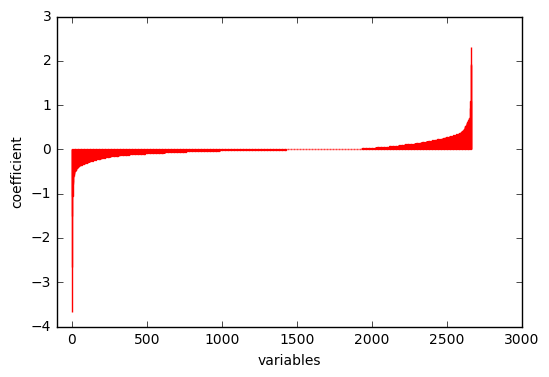

In [58]:
# look at variables with most positive and most negative coefficients
coef = lr_model.coef_.flatten()

most_pos_var_index = np.argsort(coef)[-4:][:-1]
most_neg_var_index = np.argsort(coef)[0:3]

most_pos_var = x_df_extended.columns[most_pos_var_index]
most_neg_var = x_df_extended.columns[most_neg_var_index]

print 'most positive variables'
print most_pos_var.values
print 'most negative variables'
print most_neg_var.values

plt.bar(range(len(coef)), np.sort(coef), color = 'red', edgecolor = 'red')
plt.ylabel('coefficient')
plt.xlabel('variables')
plt.xlim([-100, 3000])
plt.show()

n416=3: Other CNS condition = Yes, no handicap

n330=10: Date on Medical Exam - month & year = January-April 66

n415=3: Epileptic condition = Yes, no handicap

n1502=1: Has child ever had convulsions = No

n415=2: Epileptic condition = None

n2031=1: Abnormality of skin = No abnormality